# AutoEncoders
**Autoencoders** are a type of neural network used for unsupervised learning, primarily for dimensionality reduction and feature learning. They consist of two parts:

- Encoder: Compresses the input data into a smaller, dense representation (latent space).

- Decoder: Reconstructs the original data from the compressed representation.

The model is trained to minimize the difference between the input and the reconstructed output, making it useful for tasks like noise reduction, anomaly detection, and data compression.
## 1. Load the Data

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 256
epochs = 30

In [3]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset = mnist(train_size, transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 247kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.03MB/s]


In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

dataloaders = (train_dataloader, test_dataloader)

In [7]:
def noisify(shapes):
    return np.random.normal(loc=0.5, scale=0.3, size=shapes)

In [8]:
def plotn(n, data, noisy=False, super_res=None):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break
        preprocess = z[0].reshape(1, 28, 28) if z[0].shape[1] == 28 else z[0].reshape(1, 14, 14) if z[0].shape[1] == 14 else z[0]
        if super_res is not None:
            _transform = transforms.Resize((int(preprocess.shape[1] / super_res), int(preprocess.shape[2] / super_res)))
            preprocess = _transform(preprocess)

        if noisy:
            shapes = list(preprocess.shape)
            preprocess += noisify(shapes)

        ax[i].imshow(preprocess[0])
    plt.show()

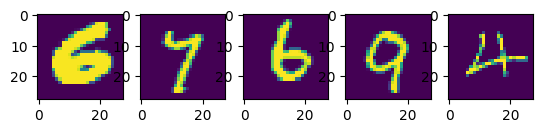

In [9]:
plotn(5, train_dataset)

## 2. Build the Model

In [25]:
# Encoder model
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=(3,3), padding='same')
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv3 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
    self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
    self.relu = nn.ReLU()

  def forward(self, input):
    hidden1 = self.maxpool1(self.relu(self.conv1(input)))
    hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
    encoded = self.maxpool3(self.relu(self.conv3(hidden2)))
    return encoded

In [26]:
# Decoder model
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample1 = nn.Upsample(scale_factor=(2, 2))
        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3, 3))
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.upsample1(self.relu(self.conv1(input)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        return decoded

In [27]:
class AutoEncoder(nn.Module):
    def __init__(self, super_resolution=False):
        super().__init__()
        if not super_resolution:
            self.encoder = Encoder()
        else:
            self.encoder = SuperResolutionEncoder()
        self.decoder = Decoder()

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

In [28]:
model = AutoEncoder().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)

loss_fn = nn.BCELoss()

## 3. Train the Model

In [29]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device, noisy=None, super_res=None):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            shapes = list(imgs.shape)

            if super_res is not None:
                shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                _transform = transforms.Resize((shapes[2], shapes[3]))
                imgs_transformed = _transform(imgs)
                imgs_transformed = imgs_transformed.to(device)

            imgs = imgs.to(device)
            labels = labels.to(device)

            if noisy is not None:
                noisy_tensor = noisy[0]
            else:
                noisy_tensor = torch.zeros(tuple(shapes)).to(device)

            if super_res is None:
                imgs_noisy = imgs + noisy_tensor
            else:
                imgs_noisy = imgs_transformed + noisy_tensor

            imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

            preds = model(imgs_noisy)
            loss = loss_fn(preds, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                shapes = list(imgs.shape)

                if super_res is not None:
                    shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                    _transform = transforms.Resize((shapes[2], shapes[3]))
                    imgs_transformed = _transform(imgs)
                    imgs_transformed = imgs_transformed.to(device)


                imgs = imgs.to(device)
                labels = labels.to(device)

                if noisy is not None:
                    test_noisy_tensor = noisy[1]
                else:
                    test_noisy_tensor = torch.zeros(tuple(shapes)).to(device)

                if super_res is None:
                    imgs_noisy = imgs + test_noisy_tensor
                else:
                    imgs_noisy = imgs_transformed + test_noisy_tensor

                imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

                preds = model(imgs_noisy)
                loss = loss_fn(preds, imgs)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()


In [30]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████| 30/30 [08:05<00:00, 16.19s/it, train loss:=0.105, test loss:=0.105]


## 4. Evaluate the Model

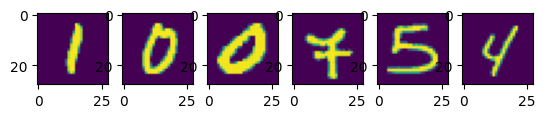

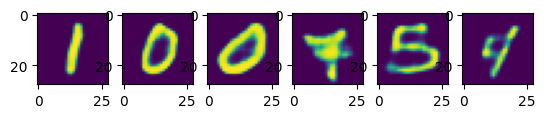

In [36]:
model.eval()
predictions = []
plots = 6
for i, data in enumerate(test_dataset):
  if i ==plots:
    break
  # Move the input data to the same device as the model
  predictions.append(model(data[0].unsqueeze(0).to(device)).detach().cpu())
plotn(plots,test_dataset)
plotn(plots, predictions)

## Denoising
Denoising, i.e. removing noise from the image. Because noise carries out a lot of useless information, autoencoder cannot fit it all into relatively small latent space, and thus it captures only important part of the image. When training denoisers, we start with original images, and use images with artificially added noise as input for autoencoder.

<ipython-input-8-e46b08be73c4>:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  preprocess += noisify(shapes)


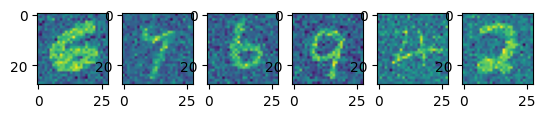

In [38]:
plotn(6, train_dataset, noisy=True)

In [39]:
model = AutoEncoder().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)

loss_fn = nn.BCELoss()

In [40]:
noisy_tensor = torch.FloatTensor(noisify([256, 1, 28, 28])).to(device)
test_noisy_tensor = torch.FloatTensor(noisify([1, 1, 28, 28])).to(device)
noisy_tensors = (noisy_tensor, test_noisy_tensor)

In [41]:
train(dataloaders, model, loss_fn, optimizer, 100, device, noisy=noisy_tensors)

100%|██████████| 100/100 [24:06<00:00, 14.46s/it, train loss:=0.117, test loss:=0.117]


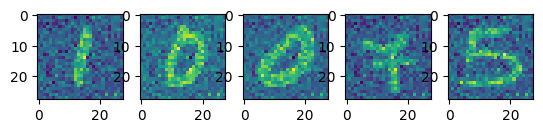

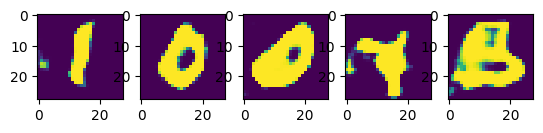

In [42]:
model.eval()
predictions = []
noise = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    shapes = data[0].shape
    noisy_data = data[0] + test_noisy_tensor[0].detach().cpu()
    noise.append(noisy_data)
    predictions.append(model(noisy_data.to(device).unsqueeze(0)).detach().cpu())
plotn(plots, noise)
plotn(plots, predictions)

## Super Resolution
Super-resolution, increasing image resolution. We start with high-resolution images, and use the image with lower resolution as the autoencoder input.


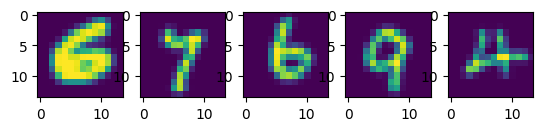

In [43]:
super_res_koeff = 2.0
plotn(5, train_dataset, super_res=super_res_koeff)

In [44]:
class SuperResolutionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        encoded = self.maxpool2(self.relu(self.conv2(hidden1)))
        return encoded

In [45]:
model = AutoEncoder(super_resolution=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [48]:
epochs = 15
train(dataloaders, model, loss_fn, optimizer, epochs, device, super_res=2.0)


100%|██████████| 15/15 [03:40<00:00, 14.69s/it, train loss:=0.114, test loss:=0.113]


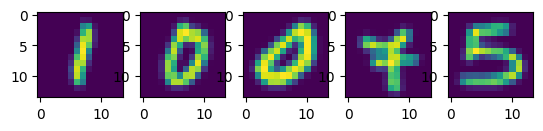

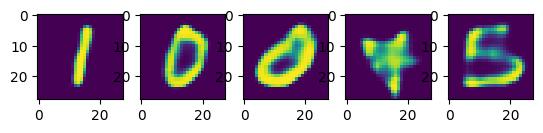

In [49]:
model.eval()
predictions = []
plots = 5
shapes = test_dataset[0][0].shape

for i, data in enumerate(test_dataset):
    if i == plots:
        break
    _transform = transforms.Resize((int(shapes[1] / super_res_koeff), int(shapes[2] / super_res_koeff)))
    predictions.append(model(_transform(data[0]).to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset, super_res=super_res_koeff)
plotn(plots, predictions)

## Variational Autoencoders (VAEs)
**Variational Autoencoders (VAEs)** are a type of autoencoder that learns to map input data to a probabilistic latent space, typically using a Gaussian distribution. Unlike regular autoencoders, VAEs introduce a "sampling" step during encoding, allowing the model to generate new data by sampling from the learned distribution. The model is trained using a combination of reconstruction loss and a regularization term (KL Divergence) to ensure the latent space follows a desired distribution, enabling generative tasks like image creation.

In [50]:
class VAEEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(784, self.intermediate_dim)
        self.z_mean = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.z_log = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.relu = nn.ReLU()
        self.device = device

    def forward(self, input):
        bs = input.shape[0]

        hidden = self.relu(self.linear(input))
        z_mean = self.z_mean(hidden)
        z_log = self.z_log(hidden)

        eps = torch.FloatTensor(np.random.normal(size=(bs, self.latent_dim))).to(device)
        z_val = z_mean + torch.exp(z_log) * eps
        return z_mean, z_log, z_val

In [51]:
class VAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(self.latent_dim, self.intermediate_dim)
        self.output = nn.Linear(self.intermediate_dim, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden = self.relu(self.linear(input))
        decoded = self.sigmoid(self.output(hidden))
        return decoded

In [52]:
class VAEAutoEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.encoder = VAEEncoder(device)
        self.decoder = VAEDecoder()
        self.z_vals = None

    def forward(self, input):
        bs, c, h, w = input.shape[0], input.shape[1], input.shape[2], input.shape[3]
        input = input.view(bs, -1)
        encoded = self.encoder(input)
        self.z_vals = encoded
        decoded = self.decoder(encoded[2])
        return decoded

    def get_zvals(self):
        return self.z_vals

In [53]:
def vae_loss(preds, targets, z_vals):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds, targets.view(targets.shape[0], -1)) * 784.0
    temp = 1.0 + z_vals[1] - torch.square(z_vals[0]) - torch.exp(z_vals[1])
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [54]:
model = VAEAutoEncoder(device).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=eps)

In [55]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            z_vals = model.get_zvals()
            loss = vae_loss(preds, imgs, z_vals)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                z_vals = model.get_zvals()
                loss = vae_loss(preds, imgs, z_vals)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()


In [56]:
epochs=15
train_vae(dataloaders, model, optimizer, epochs, device)

100%|██████████| 15/15 [03:05<00:00, 12.34s/it, train loss:=36.1, test loss:=36.5]


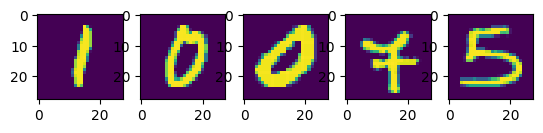

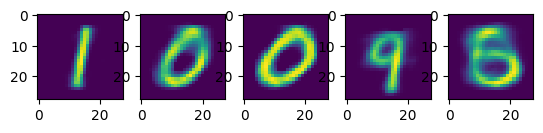

In [57]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    predictions.append(model(data[0].to(device).unsqueeze(0)).view(1, 28, 28).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

## Adversarial Auto Encoders
**Adversarial Autoencoders (AAEs)** are a type of autoencoder that combines the concepts of autoencoders and Generative Adversarial Networks (GANs). In AAEs:

- **Encoder**: Maps the input data to a latent space, similar to a regular autoencoder.

- **Discriminator**: A separate neural network acts as a "discriminator" that tries to distinguish between the encoded latent representations and a predefined prior distribution (like a Gaussian).

- **Adversarial Training**: The encoder is trained to fool the discriminator, making the encoded latent space resemble the chosen prior distribution while also minimizing reconstruction loss.

AAEs use a GAN-like approach to regularize the latent space of an autoencoder, ensuring that the learned representations are close to a desired distribution, while still allowing for reconstruction of the original input.

In [58]:
class AAEEncoder(nn.Module):
    def __init__(self, input_dim, inter_dim, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        encoded = self.linear4(hidden3)
        return encoded

In [59]:
class AAEDecoder(nn.Module):
    def __init__(self, latent_dim, inter_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        decoded = self.sigmoid(self.linear4(hidden3))
        return decoded

In [60]:
class AAEDiscriminator(nn.Module):
    def __init__(self, latent_dim, inter_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.inter_dim = inter_dim
        self.linear1 = nn.Linear(latent_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, inter_dim)
        self.linear5 = nn.Linear(inter_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        hidden4 = self.relu(self.linear4(hidden3))
        decoded = self.sigmoid(self.linear4(hidden4))
        return decoded

    def get_dims(self):
        return self.latent_dim, self.inter_dim

In [61]:
input_dims = 784
inter_dims = 1000
latent_dims = 150

In [62]:
aae_encoder = AAEEncoder(input_dims, inter_dims, latent_dims).to(device)
aae_decoder = AAEDecoder(latent_dims, inter_dims, input_dims).to(device)
aae_discriminator = AAEDiscriminator(latent_dims, int(inter_dims / 2)).to(device)

In [63]:
lr = 1e-4
regularization_lr = 5e-5

In [64]:
optim_encoder = optim.Adam(aae_encoder.parameters(), lr=lr)
optim_encoder_regularization = optim.Adam(aae_encoder.parameters(), lr=regularization_lr)

optim_decoder = optim.Adam(aae_decoder.parameters(), lr=lr)

optim_discriminator = optim.Adam(aae_discriminator.parameters(), lr=regularization_lr)

In [65]:
def train_aae(dataloaders, models, optimizers, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    enc, dec, disc = models[0], models[1], models[2]
    optim_enc, optim_enc_reg, optim_dec, optim_disc = optimizers[0], optimizers[1], optimizers[2], optimizers[3]

    eps = 1e-9

    for epoch in tqdm_iter:
        enc.train()
        dec.train()
        disc.train()

        train_reconst_loss = 0.0
        train_disc_loss = 0.0
        train_enc_loss = 0.0

        test_reconst_loss = 0.0
        test_disc_loss = 0.0
        test_enc_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.view(imgs.shape[0], -1).to(device)
            labels = labels.to(device)

            enc.zero_grad()
            dec.zero_grad()
            disc.zero_grad()

            encoded = enc(imgs)
            decoded = dec(encoded)

            reconstruction_loss = F.binary_cross_entropy(decoded, imgs)
            reconstruction_loss.backward()

            optim_enc.step()
            optim_dec.step()
            enc.eval()

            latent_dim, disc_inter_dim = disc.get_dims()
            real = torch.randn(imgs.shape[0], latent_dim).to(device)

            disc_real = disc(real)
            disc_fake = disc(enc(imgs))

            disc_loss = -torch.mean(torch.log(disc_real + eps) + torch.log(1.0 - disc_fake + eps))
            disc_loss.backward()

            optim_dec.step()
            enc.train()

            disc_fake = disc(enc(imgs))
            enc_loss = -torch.mean(torch.log(disc_fake + eps))
            enc_loss.backward()

            optim_enc_reg.step()

            train_reconst_loss += reconstruction_loss.item()
            train_disc_loss += disc_loss.item()
            train_enc_loss += enc_loss.item()

        enc.eval()
        dec.eval()
        disc.eval()

        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.view(imgs.shape[0], -1).to(device)
                labels = labels.to(device)

                encoded = enc(imgs)
                decoded = dec(encoded)

                reconstruction_loss = F.binary_cross_entropy(decoded, imgs)

                latent_dim, disc_inter_dim = disc.get_dims()
                real = torch.randn(imgs.shape[0], latent_dim).to(device)

                disc_real = disc(real)
                disc_fake = disc(enc(imgs))
                disc_loss = -torch.mean(torch.log(disc_real + eps) + torch.log(1.0 - disc_fake + eps))

                disc_fake = disc(enc(imgs))
                enc_loss = -torch.mean(torch.log(disc_fake + eps))

                test_reconst_loss += reconstruction_loss.item()
                test_disc_loss += disc_loss.item()
                test_enc_loss += enc_loss.item()

        train_reconst_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)
        train_enc_loss /= len(train_dataloader)

        test_reconst_loss /= len(test_dataloader)
        test_disc_loss /= len(test_dataloader)
        test_enc_loss /= len(test_dataloader)

        tqdm_dct = {'train reconst loss:': train_reconst_loss, 'train disc loss:': train_disc_loss, 'train enc loss': train_enc_loss, \
                        'test reconst loss:': test_reconst_loss, 'test disc loss:': test_disc_loss, 'test enc loss': test_enc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [66]:
models = (aae_encoder, aae_decoder, aae_discriminator)
optimizers = (optim_encoder, optim_encoder_regularization, optim_decoder, optim_discriminator)

In [67]:
train_aae(dataloaders, models, optimizers, epochs, device)

100%|██████████| 15/15 [05:43<00:00, 22.88s/it, train reconst loss:=0.11, train disc loss:=1.39, train enc loss=0.692, test reconst loss:=0.111, test disc loss:=1.39, test enc loss=0.692]


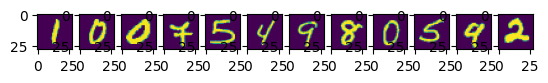

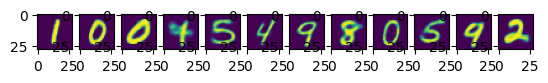

In [71]:
aae_encoder.eval()
aae_decoder.eval()
predictions = []
plots = 12
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    pred = aae_decoder(aae_encoder(data[0].to(device).unsqueeze(0).view(1, 784)))
    predictions.append(pred.view(1, 28, 28).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)